<a href="https://colab.research.google.com/github/camoalon/language_genes/blob/devel/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genes and Phonemes
In this code, we reproduce some of the results from [Creanza et al.](https://www.pnas.org/content/112/5/1265). Once reproducibility is verified, a subset of the data is used to compare the analysis method used in [Creanza et al.](https://www.pnas.org/content/112/5/1265) (PCA+Procrustes) versus the method presented in [Brown et al.](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007841) (PCCA).

# Import packages and data

## Import packages

In [68]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns


## Define Procrustes
The Procrustes transformation implemented as [scipy.spatial.procrustes](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.spatial.procrustes.html) did not seem to provide a correct result, so we decided to use the Matlab implementation of Procrustes translated to Python syntax (see [here](https://stackoverflow.com/questions/18925181/procrustes-analysis-with-numpy) for details). Hence, it is necessary to define the procrustes function below.

In [69]:
def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)

    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform

## Import data from Github

The data is stored on a private Github repository. We first clone the repositoy into the server and then read the .txt files to appropriately save the relevant data into variables.

###Load the data into the server

In [70]:
! git clone https://github.com/camoalon/language_genes.git

Cloning into 'language_genes'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 159 (delta 62), reused 43 (delta 14), pack-reused 0
Receiving objects: 100% (159/159), 22.58 MiB | 19.81 MiB/s, done.
Resolving deltas: 100% (62/62), done.


###Read the data of the PNAS paper
These are the supplementary data published together with [Creanza et al.](https://www.pnas.org/content/112/5/1265). They are only the data corresponding with the phonemes in the Ruhlen database as no data about the PHOIBLE or the alleles could be found as suplementary material of the paper. 

In [71]:
% cd language_genes/data/PNAS

/content/language_genes/data/language_genes/data/PNAS


In [72]:
paper = pd.read_csv('pnas.1424033112.sd01.txt', skiprows = 17, sep = "\t", header = None)

coordinates_paper = paper.iloc[:,7:9]
phonemes_paper = paper.iloc[:,9:737]
continents_paper = paper[6]

languages_info_paper = phonemes_paper.copy()
languages_info_paper["Continents"] = continents_paper

paper2 = pd.read_csv('pnas.1424033112.sd02.txt', skiprows = 16, sep = "\t", header = None)

labels_phonemes_paper = paper2[1]
position_phonemes_paper = paper2[0]

phonemes_info_paper = pd.DataFrame([position_phonemes_paper,labels_phonemes_paper]).T

###Read the data from Nicole's email

These are the data that Lior sent to me in a forwaded email. I assume these are just a subset of the actual data in the paper. 

In [73]:
% cd ..

/content/language_genes/data/language_genes/data


In [74]:
phonemes = pd.read_csv('Phonemes139forShannon.txt',sep='\t',header=None)
phonemes.drop(139,axis=1,inplace=True)

alleles = pd.read_csv('AlleleFrequencies_139forShannon.txt',sep='\t',header=None)
alleles.drop(139,axis=1,inplace=True)

coordinates = pd.read_csv('LongLat_Unscaled_139forShannon.txt',sep='\t',header=None)
coordinates.drop(139,axis=1,inplace=True)

languages = pd.read_csv('Names_139forShannon.txt',sep='\t')

Since in these data we do not have the continent for each set of phonemes/alleles but we do have the language name, we can extract the corresponding continents by reading the data provided in the supplementary material of the paper. 

In [75]:
languages_names = np.array(languages["Language name"])

continents = np.empty(len(languages_names),dtype="U25")

for index,elements in enumerate(languages_names):
  lang = elements[:-1]
  continents[index] = paper.loc[paper[1] == lang][6].values[0]

# Replicate data from PNAS paper
We start by replicating the analysis that led to Figure 1 (B) in [Creanza et al.](https://www.pnas.org/content/112/5/1265) to verify that the steps followed in this script are consistent with the paper. Only data from the Ruhlen database were provided, but this is enough to verify that the analysis done in this script matches the one in the paper. 

### Perform PCA on the Ruhlen database

In [76]:
pca = PCA()
pca.fit(phonemes_paper)
pca_data = pca.transform(phonemes_paper)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

phonemes_paper_pca = pd.DataFrame(pca_data, columns=labels)

phonemes_paper_pc = pd.DataFrame([phonemes_paper_pca.PC1, phonemes_paper_pca.PC2]).T

Plot the two first principal components:

Text(0, 0.5, 'PC2 - 7.1%')

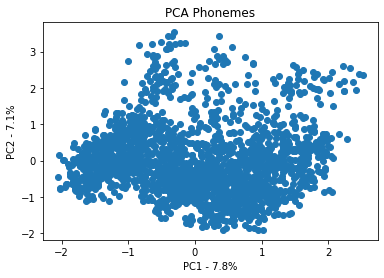

In [77]:
plt.scatter(phonemes_paper_pc['PC1'], phonemes_paper_pc['PC2'])
plt.title('PCA Phonemes')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

This result matches exactly (PC1 $7.8$%, PC2 $7.1$%) the result in Fig. S1 (A) in the supplementary material of [Creanza et al.](https://www.pnas.org/content/112/5/1265)

In [78]:
# phonemes_paper_pc_continents = phonemes_paper_pc
# phonemes_paper_pc_continents['Continents'] = continents_paper
# phonemes_paper_pc_continents.columns = ['PC1','PC2','Continents']

# g = sns.scatterplot(phonemes_paper_pc_continents['PC1'], phonemes_paper_pc_continents['PC2'],hue = phonemes_paper_pc_continents['Continents'], legend = "brief")
# g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
# plt.title('PCA Phonemes')
# plt.xlabel('PC1 - {0}%'.format(per_var[0]))
# plt.ylabel('PC2 - {0}%'.format(per_var[1]))
# plt.savefig('pca.pdf')

In [79]:
# labels_continents_paper_pca = list(phonemes_paper_pc_continents['Continents'].unique())
# latitude_paper_pca = np.empty(len(labels_continents_paper_pca))
# longitude_paper_pca = np.empty(len(labels_continents_paper_pca))
# size_paper_pca = np.empty(len(labels_continents_paper_pca))

# for i,elements in enumerate(labels_continents_paper_pca): 
#  tmp = phonemes_paper_pc_continents.loc[phonemes_paper_pc_continents['Continents'] == elements]
#  latitude_paper_pca[i] = np.mean(tmp["PC1"])
#  longitude_paper_pca[i] = np.mean(tmp["PC2"])
#  size_paper_pca[i] = len(tmp["PC1"])

# cluster_paper = pd.DataFrame([latitude_paper_pca,longitude_paper_pca,size_paper_pca,labels_continents_paper_pca]).T
# cluster_paper.columns = ['PC1','PC2','Size','Continent']

In [80]:
# g = sns.scatterplot(cluster_paper['PC1'],cluster_paper['PC2'],size=cluster_paper['Size'],hue=cluster_paper['Continent'],sizes=(50,2000))

# g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
# xaxis = plt.xlim(-2.3, 2.7)
# yaxis = plt.ylim(-2.1, 3.5)
# plt.savefig('pca_clusters.pdf')

###Perform Procrustres analysis on the first two Principal Components

In [81]:
d_paper, Z_paper, t_paper = procrustes(coordinates_paper.values, phonemes_paper_pc.values)

Plot the result of the procurstes analysis on the two principal components:

0.3662383058032033


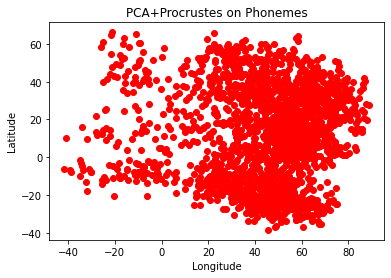

In [82]:
plt.scatter(Z_paper.T[1], Z_paper.T[0], c = "r")
plt.title('PCA+Procrustes on Phonemes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
t0 = np.sqrt(1-d_paper)
print(t0)

This result does not quite match the result from Fig. 1 (A) in [Creanza et al.](https://www.pnas.org/content/112/5/1265), where the similarity statistic $t_0$ was reported to be $0.57$. In our case the similarity statistic was about $0.37$ (reported above). However, the range in the x-axis does not match the one in Fig. 1 (A) either. This suggests that the coordinates reported in the supplementary data and the ones used in the analysis for the paper differ by some constant (as is also suggested by Nicole's email on the scaled vs unscaled coordinates). This slight modification can be the cause of discrepancy observed in the value of the similarity statistic. For this reason, we proceed our analysis.

###Label the data with the corresponding continent

0.3662383058032033


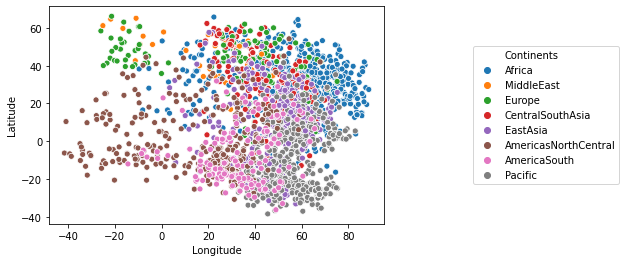

In [83]:
result_paper = pd.DataFrame(Z_paper)
result_paper['Continents'] = continents_paper
result_paper.columns = ['Latitude','Longitude','Continents']

g = sns.scatterplot(result_paper['Longitude'], result_paper['Latitude'],hue = result_paper['Continents'], legend = "brief")
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

t0 = np.sqrt(1-d_paper)
print(t0)

This plot is identical to the previous one with the only difference that now the color for each of the points correspond to the continent where the language is spoken,

###Cluster the data according to the continent
We proceed as in [Creanza et al.](https://www.pnas.org/content/112/5/1265), where the data resulting from the previous figure are lumped into clusters and represented with circles centered at the coordinate mean of the coordinates fo the languages in the continent and with size proportional to the number of languages in the continent.

In [84]:
labels_continents_paper = list(result_paper['Continents'].unique())
latitude_paper = np.empty(len(labels_continents_paper))
longitude_paper = np.empty(len(labels_continents_paper))
size_paper = np.empty(len(labels_continents_paper))

for i,elements in enumerate(labels_continents_paper): 
  tmp = result_paper.loc[result_paper['Continents'] == elements]
  latitude_paper[i] = np.mean(tmp["Latitude"])
  longitude_paper[i] = np.mean(tmp["Longitude"])
  size_paper[i] = len(tmp["Latitude"])

cluster_paper = pd.DataFrame([latitude_paper,longitude_paper,size_paper,labels_continents_paper]).T
cluster_paper.columns = ['Latitude','Longitude','Size','Continent']

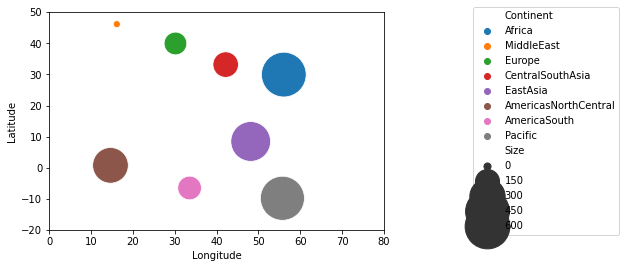

In [85]:
g = sns.scatterplot(cluster_paper['Longitude'],cluster_paper['Latitude'],size=cluster_paper['Size'],hue=cluster_paper['Continent'],sizes=(50,2000))

g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
yaxis = plt.xlim(0, 80)
xaxis = plt.ylim(-20, 50)
plt.savefig('pca_clusters_procrustes.pdf')

This figure is very much the same as Fig. 1 (A) in [Creanza et al.](https://www.pnas.org/content/112/5/1265), with the difference that this plot is somehow translated and rotated with respect to the original Fig. 1 (A). Again, we think this is a consequence of the scaling of the coordinates and as such it seems that the results for the Ruhlen databse in [Creanza et al.](https://www.pnas.org/content/112/5/1265) can be reproduced in this script.



# Compare PCA+Procrustes with PCCA
In this section we use a reduced version of the data (obtained from Nicole's email). This time we have phoneme information as well as allele information. We perform two different analysis of the data:
1.   The same analysis as the one presented in [Creanza et al.](https://www.pnas.org/content/112/5/1265), which was just reproduced in the previous section. To do this we do PCA+Procrustes of both the phonemes and the alleles, and then compare both plots of the prinicipal components since they have been expressed in the coordinates framework thanks to the Procrustes analysis.
2.   A PCCA analysis as described in [Brown et al.](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007841), where we use allele information to find the projection for the phoneme data. No coordinate information is needed for this analysis since alleles and phonemes information can be combined directly in a single plot. 

##PCA+Procrustes
We perform the analysis following the approach in [Creanza et al.](https://www.pnas.org/content/112/5/1265), identical to the one in the previous subsection.

### On the Alleles

We perform PCA on the alleles as in the previous section.

In [86]:
pca = PCA()
pca.fit(alleles.T)
pca_alleles = pca.transform(alleles.T)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

alleles_pca = pd.DataFrame(pca_alleles, columns=labels)
alleles_pca_loadings = pd.DataFrame(pca.components_.T)

This time, we use the elbow method to asses how many principal components are necessasry to keep the relevant information for the further analysis.

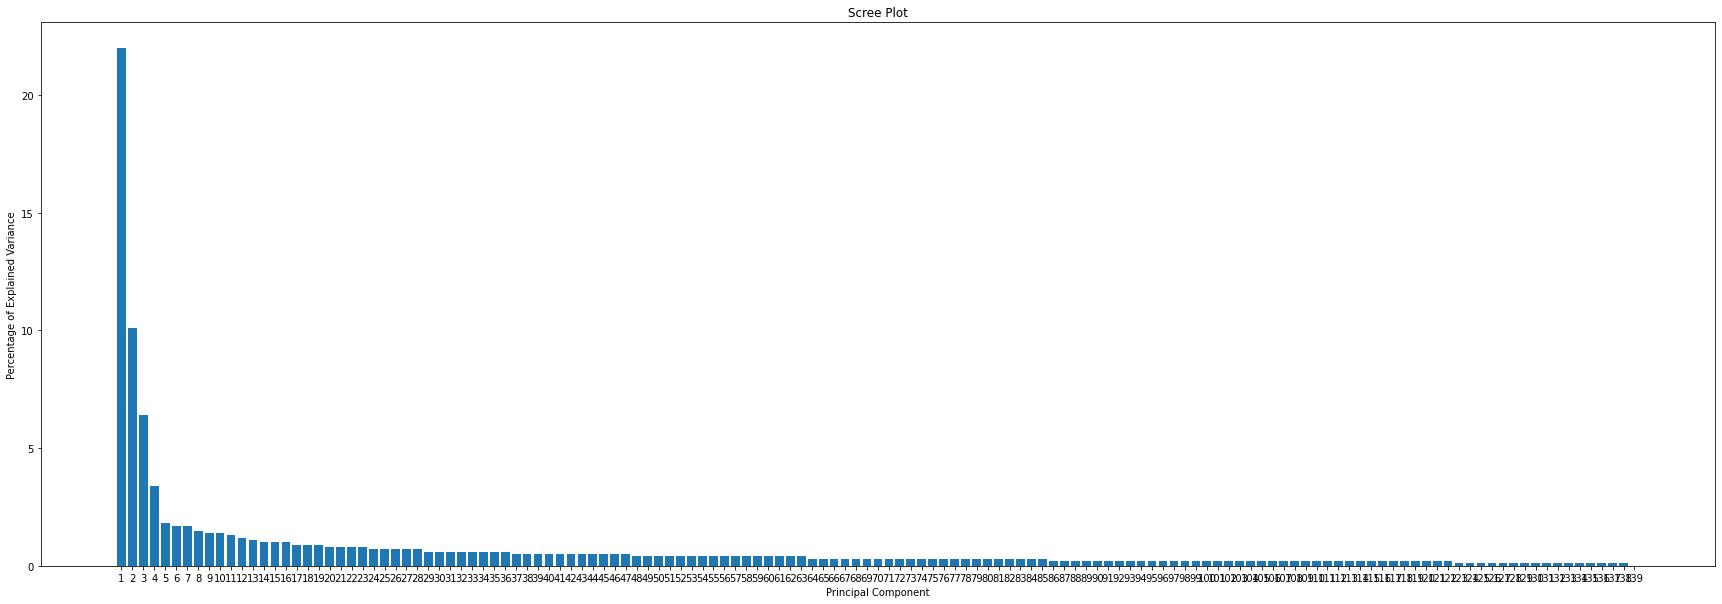

In [87]:
fig, ax = plt.subplots(figsize=(30, 10))
labels_scree = [str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels_scree)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

Looking at the plot, it seems like 2 (above 5% explained variance) principal components could be a good number to keep since more than 90% of explained variance lies in the first 2 principal components.

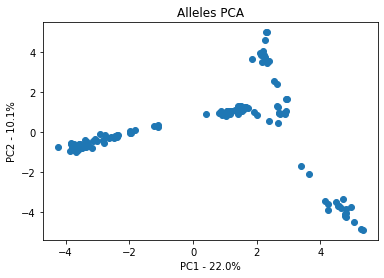

In [88]:
alleles_pc = pd.DataFrame([alleles_pca.PC1, alleles_pca.PC2]).T

plt.scatter(alleles_pc['PC1'], alleles_pc['PC2'])
plt.title('Alleles PCA')
xlabel = plt.xlabel('PC1 - {0}%'.format(per_var[0]))
ylabel = plt.ylabel('PC2 - {0}%'.format(per_var[1]))

We perform Procrustes on the PC and we plot it as in the previous section.

In [89]:
d_alleles, Z_alleles, t_alleles = procrustes(coordinates.T.values, alleles_pc.values)

0.4979753699793969


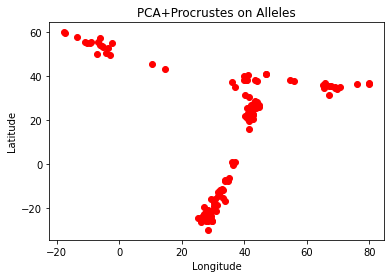

In [90]:
plt.scatter(Z_alleles.T[0], Z_alleles.T[1], c = "r")
plt.title('PCA+Procrustes on Alleles')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

t0 = np.sqrt(1-d_alleles)
print(t0)

We label the data with the corresponding continent for each of the points above, just like in the previous section. 

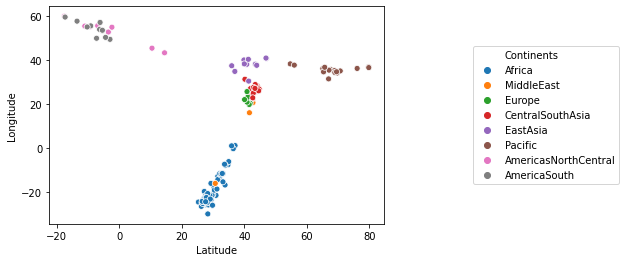

In [91]:
result_alleles = pd.DataFrame(Z_alleles)
result_alleles['Continents'] = continents
result_alleles.columns = ['Latitude','Longitude','Continents']

g = sns.scatterplot(result_alleles['Latitude'], result_alleles['Longitude'], hue = result_alleles['Continents'], legend = "brief")
legend = g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)


We lump the data by continent in the exact same way as done in the previous section.

In [92]:
latitude_alleles = np.empty(len(continents))
longitude_alleles = np.empty(len(continents))
size_alleles = np.empty(len(continents))

for i,elements in enumerate(continents): 
  tmp = result_alleles.loc[result_alleles['Continents'] == elements]
  latitude_alleles[i] = np.mean(tmp["Latitude"])
  longitude_alleles[i] = np.mean(tmp["Longitude"])
  size_alleles[i] = len(tmp["Latitude"])

cluster_alleles = pd.DataFrame([latitude_alleles,longitude_alleles,size_alleles,continents]).T
cluster_alleles.columns = ['Latitude','Longitude','Size','Continent']

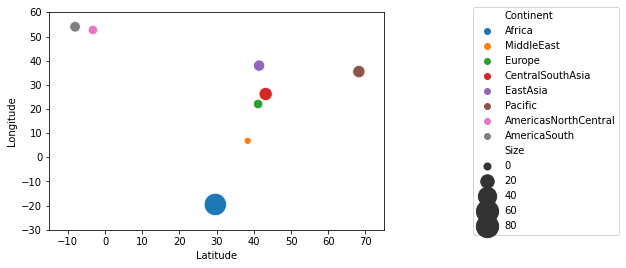

In [93]:
g = sns.scatterplot(cluster_alleles['Latitude'],cluster_alleles['Longitude'],size=cluster_alleles['Size'],hue=cluster_alleles['Continent'],sizes=(50,500))

g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
yaxis = plt.xlim(-15,75)
xaxis = plt.ylim(-30,60)

###On the Phonemes

We perform PCA on the phonemes as in the previous section.

In [94]:
pca = PCA()
pca.fit(phonemes.T)
pca_phonemes = pca.transform(phonemes.T)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

phonemes_pca = pd.DataFrame(pca_phonemes, columns=labels)
phonemes_pca_loadings = pd.DataFrame(pca.components_.T)
phonemes_pca_loadings.index = labels_phonemes_paper

Again, we use the elbow method to asses how many principal components are necessasry to keep the relevant information for the further analysis.

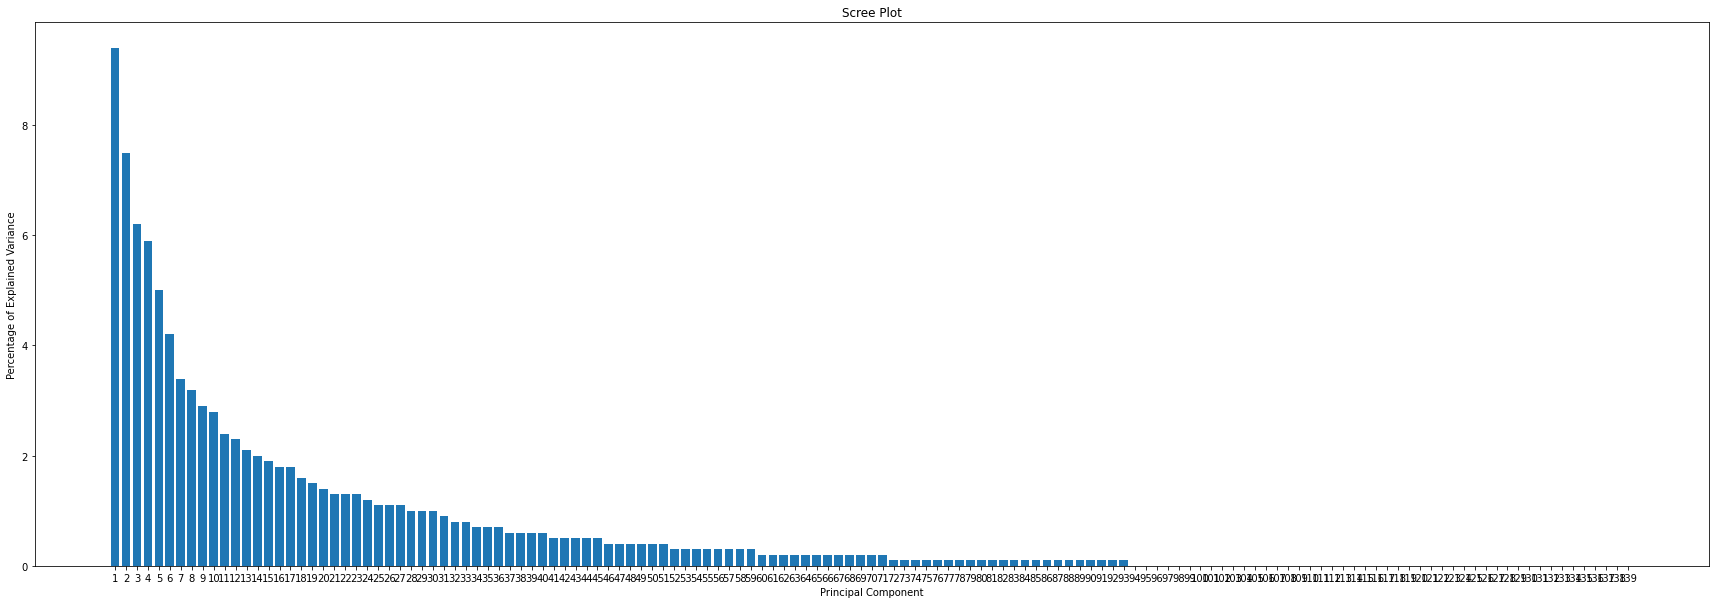

In [95]:
fig, ax = plt.subplots(figsize=(30, 10))
labels_scree = [str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels_scree)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

Looking at the plot, it seems like 10 (above 2% explained variance) principal components could be a good number to keep. In what follows below, we plot the first to components only to emulate the analysis done in [Creanza et al.](https://www.pnas.org/content/112/5/1265), but later on we will use 10 principal components for the PCCA analysis.

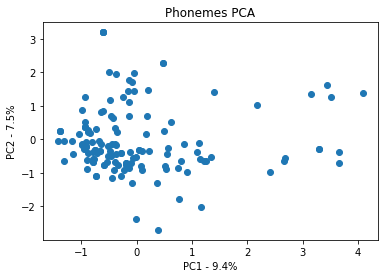

In [96]:
phonemes_pc = pd.DataFrame([phonemes_pca.PC1, phonemes_pca.PC2]).T

plt.scatter(phonemes_pc['PC1'], phonemes_pc['PC2'])
plt.title('Phonemes PCA')
xlabel = plt.xlabel('PC1 - {0}%'.format(per_var[0]))
ylabel = plt.ylabel('PC2 - {0}%'.format(per_var[1]))

We perform Procrustes on the PC and we plot it as in the previous section.

In [97]:
d_phonemes, Z_phonemes, t_phonemes = procrustes(coordinates.T.values, phonemes_pc.values)

0.16257693491744693


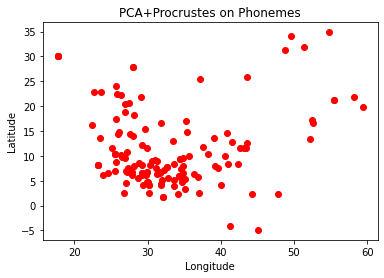

In [98]:
plt.scatter(Z_phonemes.T[0], Z_phonemes.T[1], c = "r")
plt.title('PCA+Procrustes on Phonemes')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
t0 = np.sqrt(1-d_phonemes)
print(t0)

We label the data with the corresponding contient for each of the points above, just like in the previous section. 

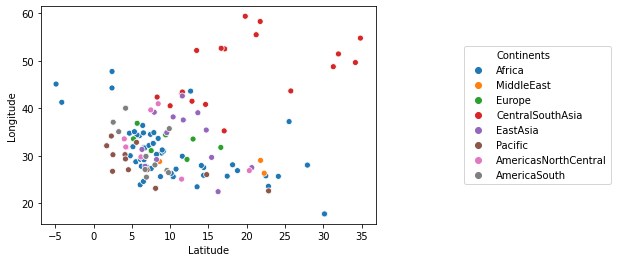

In [99]:
result_phonemes = pd.DataFrame(Z_phonemes)
result_phonemes['Continents'] = continents
result_phonemes.columns = ['Longitude','Latitude','Continents']

g = sns.scatterplot(result_phonemes['Latitude'],result_phonemes['Longitude'],hue = result_phonemes['Continents'], legend = "brief")
legend = g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

We lump the data by continent in the exact same way as done in the previous section.

In [100]:
latitude_phonemes = np.empty(len(continents))
longitude_phonemes = np.empty(len(continents))
size_phonemes = np.empty(len(continents))

for i,elements in enumerate(continents): 
  tmp = result_phonemes.loc[result_phonemes['Continents'] == elements]
  latitude_phonemes[i] = np.mean(tmp["Latitude"])
  longitude_phonemes[i] = np.mean(tmp["Longitude"])
  size_phonemes[i] = len(tmp["Latitude"])

cluster_phonemes = pd.DataFrame([latitude_phonemes,longitude_phonemes,size_phonemes,continents]).T
cluster_phonemes.columns = ['Latitude','Longitude','Size','Continent']

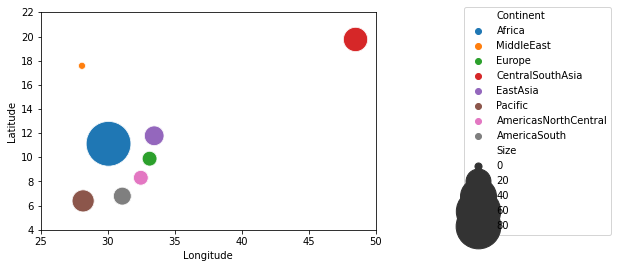

In [101]:
g = sns.scatterplot(cluster_phonemes['Longitude'],cluster_phonemes['Latitude'],size=cluster_phonemes['Size'],hue=cluster_phonemes['Continent'],sizes=(50,2000))

g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
yaxis = plt.xlim(25,50)
xaxis = plt.ylim(4,22)

## PCCA
We perform the analysis described in [Brown et al](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007841). In particular, we use allele information to find the projection for the phoneme data. The first two components of the projection are plotted below. 

In [102]:
n_components = 2
cca = CCA(n_components)

alleles_pcca = alleles_pca.iloc[:,0:2]
phonemes_pcca = phonemes_pca.iloc[:,0:10]

cca.fit(phonemes_pcca,alleles_pcca)
Y = cca.transform(phonemes_pcca)

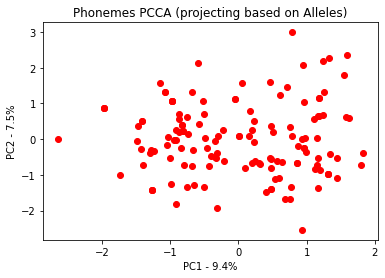

In [103]:
plot = plt.scatter(Y.T[0], Y.T[1], c = "r")
plt.title('Phonemes PCCA (projecting based on Alleles)')
xlabel = plt.xlabel('PC1 - {0}%'.format(per_var[0]))
ylabel = plt.ylabel('PC2 - {0}%'.format(per_var[1]))

We label the data with the corresponding contient for each of the points above, just like in the previous section. 

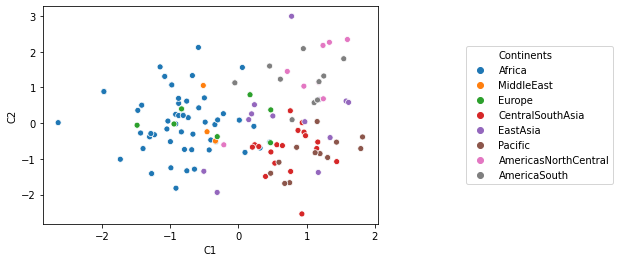

In [104]:
result_cca = pd.DataFrame(Y)
result_cca['Continents'] = continents
result_cca.columns = ['C1','C2','Continents']

g = sns.scatterplot(result_cca['C1'], result_cca['C2'], hue = result_cca['Continents'], legend = "brief")
legend = g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

We lump the data in the exact same way as in the previous analysis for the sake of a simpler comparison.

In [105]:
latitude_cca = np.empty(len(continents))
longitude_cca = np.empty(len(continents))
size_cca = np.empty(len(continents))

for i,elements in enumerate(continents): 
  tmp = result_cca.loc[result_cca['Continents'] == elements]
  latitude_cca[i] = np.mean(tmp["C1"])
  longitude_cca[i] = np.mean(tmp["C2"])
  size_cca[i] = len(tmp["C1"])

cluster_cca = pd.DataFrame([latitude_cca,longitude_cca,size_cca,continents]).T
cluster_cca.columns = ['C1','C2','Size','Continent']

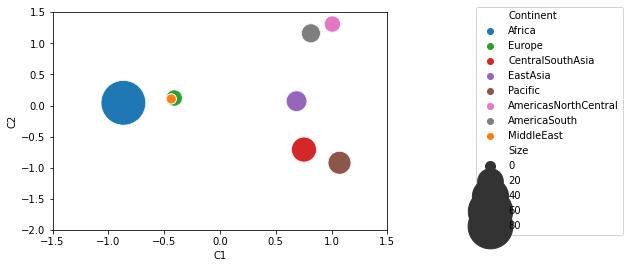

In [106]:
# Change order of continents to prevent Europe from hiding MiddleEast
cluster_cca_middleeast = cluster_cca[cluster_cca['Continent'] == 'MiddleEast']
cluster_cca_no_middleeast = cluster_cca[cluster_cca['Continent'] != 'MiddleEast']
cluster_cca_ordered = cluster_cca_no_middleeast.append(cluster_cca_middleeast)

# Keeping palette consistent with other plots despite change in order
current_palette = sns.color_palette()
color = [current_palette[0],current_palette[2],current_palette[3],current_palette[4],current_palette[5],current_palette[6],current_palette[7],current_palette[1]]

# Plot
g = sns.scatterplot(cluster_cca_ordered['C1'],cluster_cca_ordered['C2'],size=cluster_cca_ordered['Size'],hue=cluster_cca_ordered['Continent'],sizes=(100,2000),palette=color)

xaxis = plt.xlim(-1.5,1.5)
yaxis = plt.ylim(-2,1.5)

legend = g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.savefig('cca_clusters.pdf')

Now instead of lumping the data we propose a better visualization, where each of the points is joint to the center through a line. 

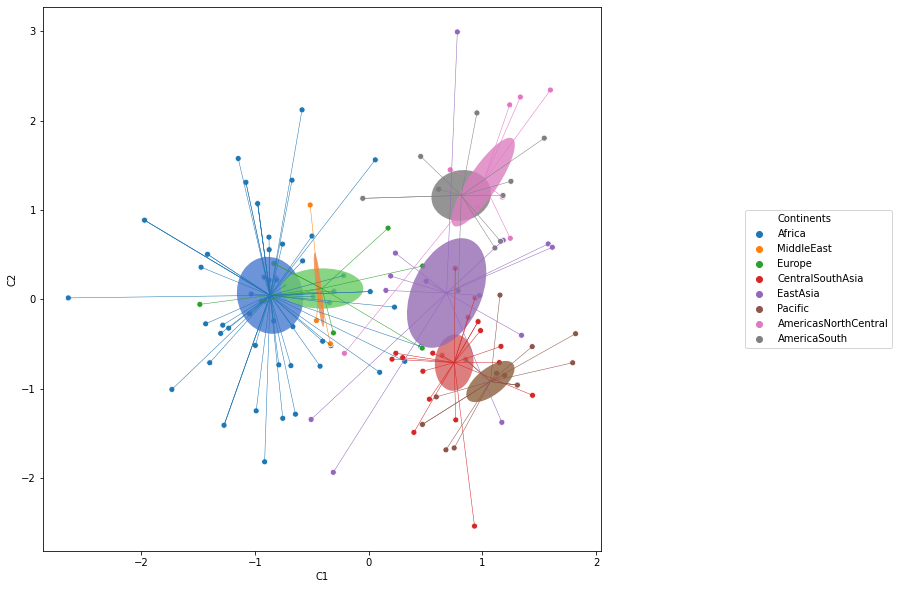

In [195]:
continents_unique, index = np.unique(continents, return_index=True)
fig, ax = plt.subplots(figsize=(10, 10))

for i,elements in enumerate(continents): 
  tmp = result_cca.loc[result_cca['Continents'] == elements]
  center_x = np.mean(tmp["C1"])
  center_y = np.mean(tmp["C2"])
  clr = sns.color_palette()[[j for j, x in enumerate(elements == continents_unique[np.argsort(index)]) if x][0]]
  plt.plot([center_x, result_cca['C1'][i]], [center_y, result_cca['C2'][i]], linewidth=.5, color = clr)

ax = sns.scatterplot(result_cca['C1'], result_cca['C2'], hue = result_cca['Continents'], sizes = 20)
legend = ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

u = np.array([1,0])

for elements in continents_unique:

# Take the data from a continent (2-D coordinates of the points) 
  tmp = result_cca.loc[result_cca['Continents'] == elements]

# Compute the center of the ellipse
  center_x = np.mean(tmp["C1"])
  center_y = np.mean(tmp["C2"])
  clr = sns.color_palette("muted")[[j for j, x in enumerate(elements == continents_unique[np.argsort(index)]) if x][0]]

# Do PCA on the points to find the directions of maximal variance
  pca = PCA()
  pca.fit(tmp.drop("Continents", axis = 1))

# Find the variance on each of those directions, as well as the directions
  size = pca.explained_variance_

  if pca.components_[0][1] < 0:
    v[1] = abs(pca.components_[0][1])
    v[0] = -1*pca.components_[0][0]
  else:
    v = pca.components_[0]
  c = np.dot(u,v)/np.linalg.norm(v)
  ang = np.arccos(c)*180/np.pi

# Draw an elipse with that orientation
  ellipse = Ellipse(xy=(center_x, center_y), width = np.sqrt(size[0]), height = np.sqrt(size[1]), angle = ang, edgecolor='None', fc=clr, alpha = 0.8)
  ax.add_patch(ellipse)


## PCCA Loadings

Now, in order to figure out what phonemes are responsible of the clustering we look at the loadings. In order to find the corresponding phonemes, we need to combine the loadings from CCA with the loadings from the PCA. In particular, the algebra goes as follows:

Let us call $y$ the base of vectors from PCA, and $z$ the base of vectors from CCA. $x$ represents the standard base in which the measurements were taken. Then:

$$y_i = \sum_{k=1}^{M}p^i_k x_k$$
$$z_j = \sum_{k=1}^{N}c^j_k y_k,$$
where $p$ are the loadings from PCA and $c$ are the loadings from CCA. Hence, if we want to find the loadings that relate $z$ to $x$, $\sum_{k=1}^{N}c^j_k p_i^k$ is the loading in each vector $z_j$ for each $x_i$.

We can compute this for all the vectors in matrix form as:

$$
\begin{bmatrix} c^1_1 & \dots & c^1_{10} \\
                \vdots & & \vdots \\
                c^{10}_1 & \dots & c^{10}_{10}
\end{bmatrix}
\begin{bmatrix} p_{1}^{1} & \dots & p^1_{728} \\
                \vdots & & \vdots \\
                p_{1}^{10} & \dots & p^{10}_{728}
\end{bmatrix}
$$

This operation is computed bellow and stored in phonemes_loadings.

In [113]:
phonemes_cca_loadings = pd.DataFrame(getattr(cca, "x_loadings_"))
phonemes_loadings = np.abs(phonemes_pca_loadings.iloc[:,0:10].dot(phonemes_cca_loadings))

We choose the number of phonemes responsible for the clustering based on the percentage of explained variance that they contribute to, first for the x-axis and then for the y-axis.

### For the x-axis:

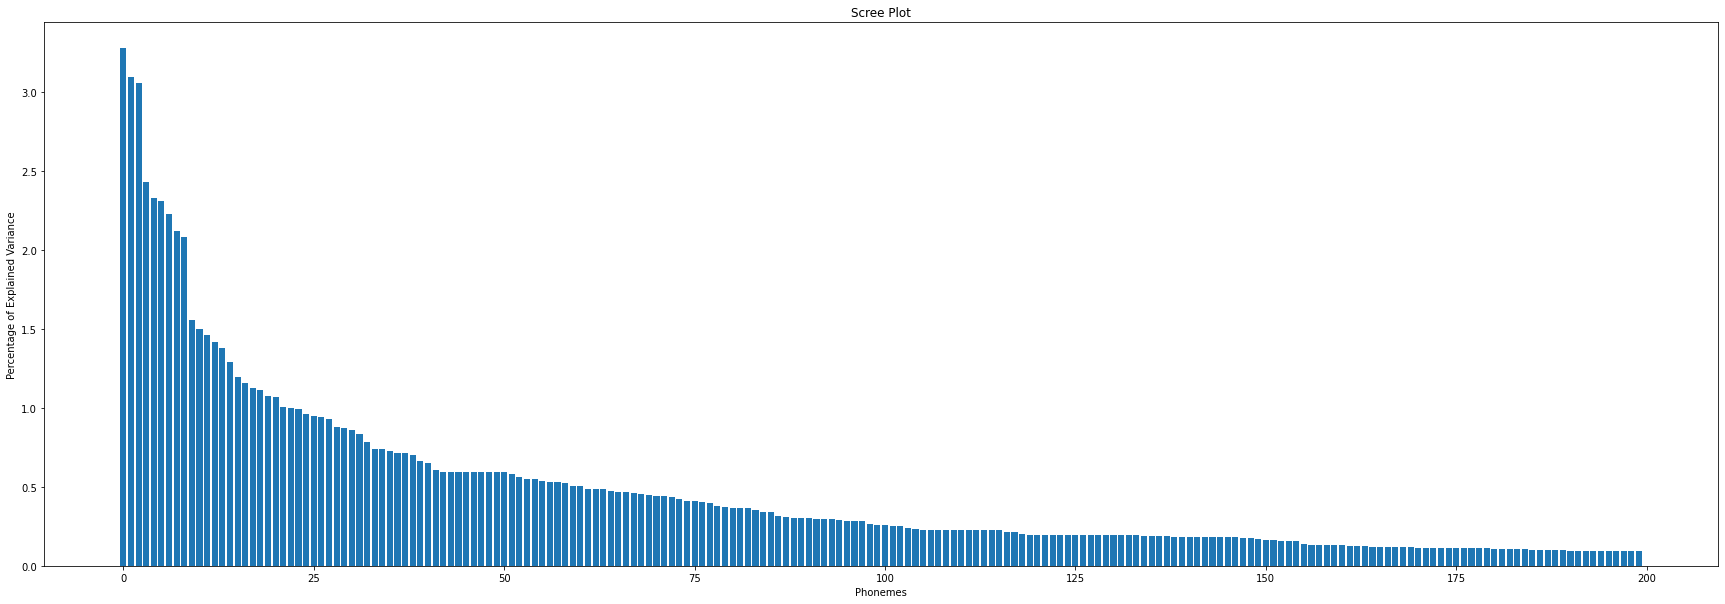

In [114]:
phonemes_loadings_sorted_xaxis = phonemes_loadings[0].sort_values(ascending = False)
phonemes_variance_xaxis = phonemes_loadings_sorted_xaxis/np.sum(phonemes_loadings_sorted_xaxis) * 100

upper_limit = 200

fig, ax = plt.subplots(figsize=(30, 10))
plt.bar(range(0,len(phonemes_variance_xaxis[0:upper_limit])), phonemes_variance_xaxis[0:upper_limit])

plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Phonemes')
plt.title('Scree Plot')
plt.show()

We decide to choose the first 9 phonemes, which together contribute more than 20% to the explained variance. Hence, the phonemes that are responsible for the majority of the clustering along the x-axis i.e. the phonemes that separate languages in Africa, Europe, and Asia+America+Pacific are: 

In [115]:
phonemes_x = list(phonemes_loadings_sorted_xaxis[0:9].index)
phonemes_x

['n˜', 'ɔ', 'f', 'ᴺc', 'd', 'w', 'ɛ', 'ɡ', 'b']

And now we compare this result with the loadings of PCA only. We choose the same number of phonemes as in the previous analysis for the sake of comparison, but unfortunately we do not get the same relevant phonemes as in the previous analysis. 

In [116]:
phonemes_pca_loadings_sorted_xaxis = phonemes_pca_loadings[0].sort_values(ascending = False)
phonemes_pca_x = list(phonemes_pca_loadings_sorted_xaxis[0:9].index)
phonemes_pca_x

['tʰ', 'kʰ', 'pʰ', 'ɡ̌', 'ṭ', 'čʰ', 'ḍ', 'č', 'ṭʰ']

### For the y-axis:

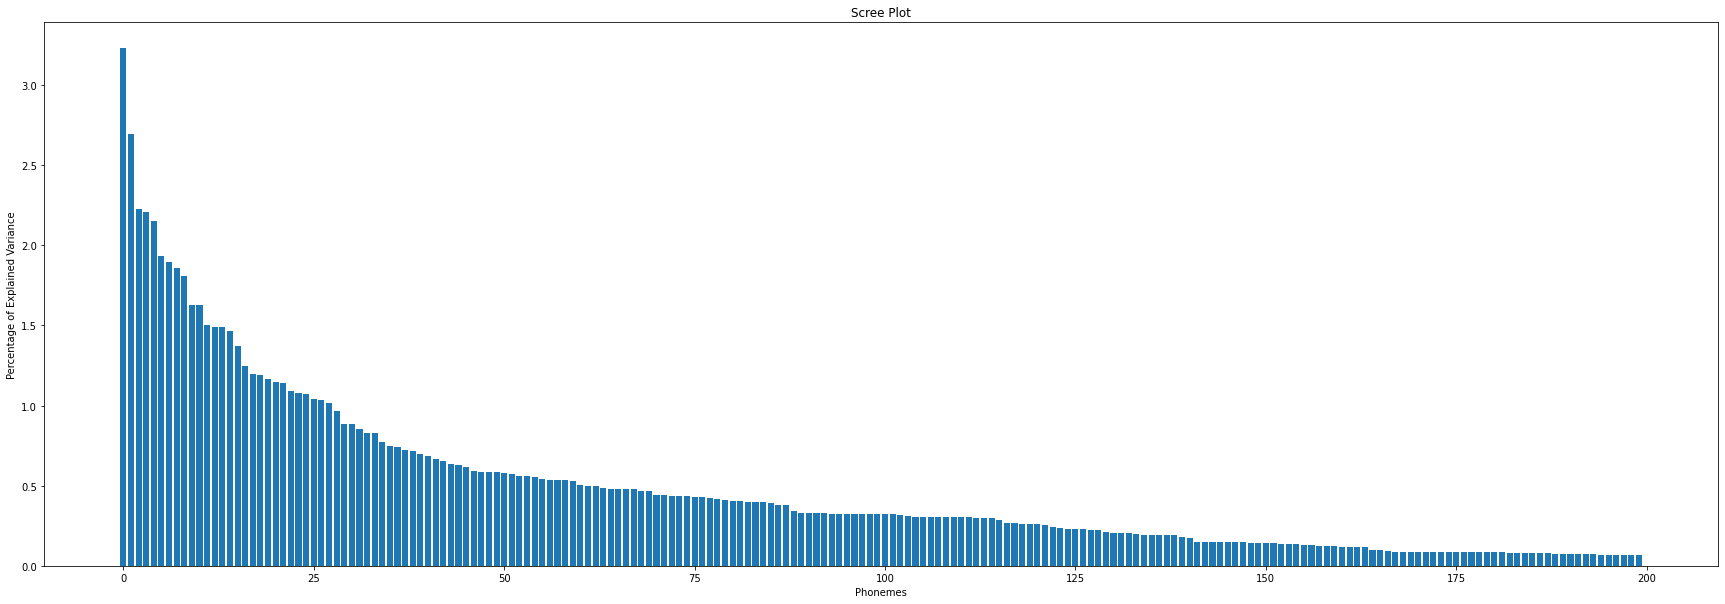

In [117]:
phonemes_loadings_sorted_yaxis = phonemes_loadings[1].sort_values(ascending = False)
phonemes_variance_yaxis = phonemes_loadings_sorted_yaxis/np.sum(phonemes_loadings_sorted_yaxis) * 100

upper_limit = 200

fig, ax = plt.subplots(figsize=(30, 10))
plt.bar(range(0,len(phonemes_variance_yaxis[0:upper_limit])), phonemes_variance_yaxis[0:upper_limit])

plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Phonemes')
plt.title('Scree Plot')
plt.show()

This time we also choose the first 9 phonemes, which together contribute once again to more than 20% to the explained variance. Hence, the phonemes that are responsible for the majority of the clustering along the x-axis i.e. the phonemes that separate languages in America, South Asia+Pacific and Africa+Europe+East Asia are:

In [118]:
phonemes_y = list(phonemes_loadings_sorted_yaxis[0:9].index)
phonemes_y 

['ʔ', 'š', 'ɨ', 'ŋ', 'č', 'w', 'kˀ', 'vː', 'b']

And now we compare this result with the loadings of PCA only. We choose the same number of phonemes as in the previous analysis for the sake of comparison, but unfortunately we do not get the same relevant phonemes as in the previous analysis.

In [119]:
phonemes_pca_loadings_sorted_yaxis = phonemes_pca_loadings[1].sort_values(ascending = False)
phonemes_pca_y = list(phonemes_pca_loadings_sorted_yaxis[0:9].index)
phonemes_pca_y

['I', 'ʊ', 'ɔ', 'ɛ', 'vː', 'ɗ', 'ɓ', 'cː', 'v̤']

###Sanity check

We evaluate the incidence of each of the found relevant phonemes in the given languages to get an intuition of the meaning of the previous result. 

In [120]:
phonemes_x_index = np.empty(len(phonemes_x))
phonemes_y_index = np.empty(len(phonemes_y))

for i,phoneme in enumerate(phonemes_x):
  phonemes_x_index[i] = phonemes_info_paper[phonemes_info_paper[1] == phoneme][0]-1
for i,phoneme in enumerate(phonemes_y):
  phonemes_y_index[i] = phonemes_info_paper[phonemes_info_paper[1] == phoneme][0]-1

In [121]:
languages_x = pd.DataFrame(columns = ['Continents','Languages','Phonemes'])
languages_x_tmp = pd.DataFrame(columns = ['Continents','Languages','Phonemes'])

for continent in continents_paper.unique():
  for i in range(0,len(phonemes_x)):
    languages = languages_info_paper[languages_info_paper[phonemes_x_index[i]] == 1]['Continents']
    current_language = list(languages).count(continent)/list(continents_paper).count(continent)
    current_continent = continent
    current_phoneme = phonemes_x[i]
    addition = [current_continent, current_language, current_phoneme]
    languages_x_tmp.loc[i] = addition
  languages_x = languages_x.append(languages_x_tmp, ignore_index = True)


languages_y = pd.DataFrame(columns = ['Continents','Languages','Phonemes'])
languages_y_tmp = pd.DataFrame(columns = ['Continents','Languages','Phonemes'])

for continent in continents_paper.unique():
  for i in range(0,len(phonemes_y)):
    languages = languages_info_paper[languages_info_paper[phonemes_y_index[i]] == 1]['Continents']
    current_language = list(languages).count(continent)/list(continents_paper).count(continent)
    current_continent = continent
    current_phoneme = phonemes_y[i]
    addition = [current_continent, current_language, current_phoneme]
    languages_y_tmp.loc[i] = addition
  languages_y = languages_y.append(languages_y_tmp, ignore_index = True)

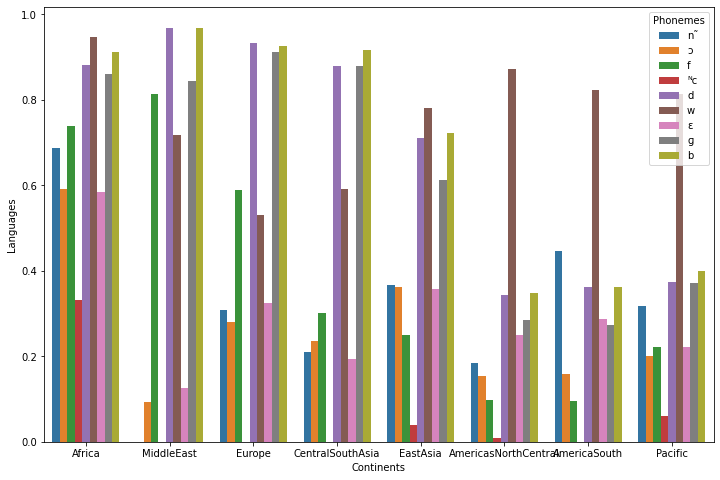

In [122]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))
sns.barplot(data = languages_x,x ='Continents', y ='Languages', hue = 'Phonemes')
plt.savefig('sanity_check_x.pdf')

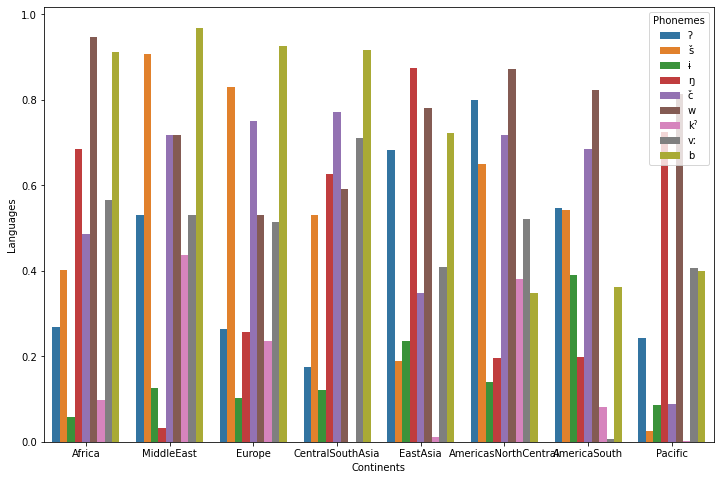

In [123]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))
sns.barplot(data = languages_y,x ='Continents', y ='Languages', hue = 'Phonemes')
plt.savefig('sanity_check_y.pdf')

We now do the same for the phonemes obtained by inspecting the PCA loadings only (as opposed to the PCCA loadings) to intuitively observe if this result is correct. 

In [124]:
phonemes_pca_x_index = []
phonemes_pca_y_index = []

for i,phoneme in enumerate(phonemes_pca_x):
  phonemes_pca_x_index.append(phonemes_info_paper[phonemes_info_paper[1] == phoneme][0].item() -1)

for i,phoneme in enumerate(phonemes_pca_y[0:-2]):
    phonemes_pca_y_index.append(phonemes_info_paper[phonemes_info_paper[1] == phoneme][0].item()-1)
    # Because the last two phonemes appear twice in the database, we need to add them by hand
phonemes_pca_y_index.append(phonemes_info_paper[phonemes_info_paper[1] == phonemes_pca_y[-2]].iloc[0,0]-1)
phonemes_pca_y_index.append(phonemes_info_paper[phonemes_info_paper[1] == phonemes_pca_y[-1]].iloc[0,0]-1)


In [125]:
languages_x = pd.DataFrame(columns = ['Continents','Languages','Phonemes'])
languages_x_tmp = pd.DataFrame(columns = ['Continents','Languages','Phonemes'])

for continent in continents_paper.unique():
  for i in range(0,len(phonemes_pca_x)):
    languages = languages_info_paper[languages_info_paper[phonemes_pca_x_index[i]] == 1]['Continents']
    current_language = list(languages).count(continent)/list(continents_paper).count(continent)
    current_continent = continent
    current_phoneme = phonemes_pca_x[i]
    addition = [current_continent, current_language, current_phoneme]
    languages_x_tmp.loc[i] = addition
  languages_x = languages_x.append(languages_x_tmp, ignore_index = True)


languages_y = pd.DataFrame(columns = ['Continents','Languages','Phonemes'])
languages_y_tmp = pd.DataFrame(columns = ['Continents','Languages','Phonemes'])

for continent in continents_paper.unique():
  for i in range(0,len(phonemes_pca_y)):
    languages = languages_info_paper[languages_info_paper[phonemes_pca_y_index[i]] == 1]['Continents']
    current_language = list(languages).count(continent)/list(continents_paper).count(continent)
    current_continent = continent
    current_phoneme = phonemes_pca_y[i]
    addition = [current_continent, current_language, current_phoneme]
    languages_y_tmp.loc[i] = addition
  languages_y = languages_y.append(languages_y_tmp, ignore_index = True)

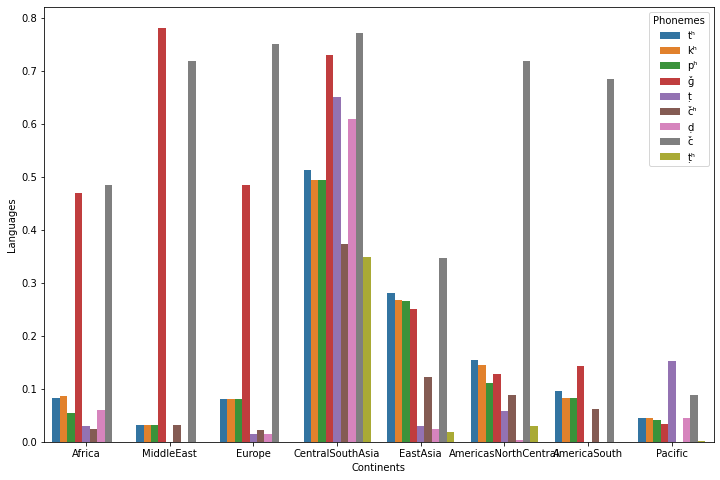

In [126]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))
sns.barplot(data = languages_x,x ='Continents', y ='Languages', hue = 'Phonemes')

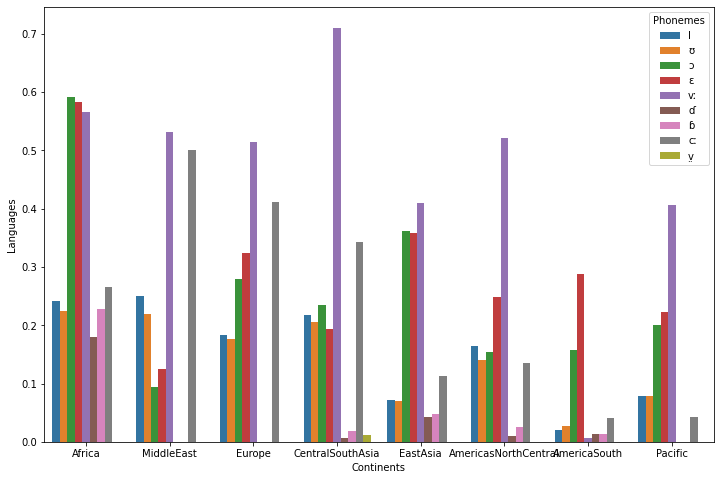

In [127]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))
sns.barplot(data = languages_y,x ='Continents', y ='Languages', hue = 'Phonemes')

## PCCA Validation

### Validation 1: random sort of the labels

We perform the exact same analysis, but this time randomly assigning the continents to each of the rows (each row corresponds to a language). 

In [128]:
# Copy continent list and randomize it
continents_randomsort = continents.copy()
np.random.shuffle (continents_randomsort)

# Copy result_cca DataFrame and replace continents column
result_cca_randomsort = result_cca.copy()
result_cca_randomsort['Continents'] = continents_randomsort

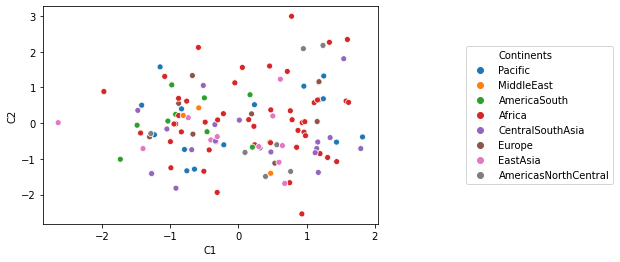

In [129]:
g = sns.scatterplot(result_cca_randomsort['C1'], result_cca_randomsort['C2'], hue = result_cca_randomsort['Continents'], legend = "brief")
legend = g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

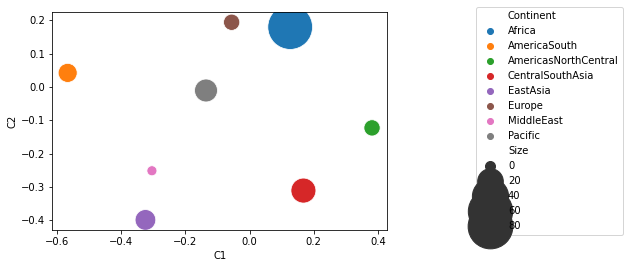

In [130]:
# Generate clusters
latitude_cca_randomsort = np.empty(len(np.unique(continents_randomsort)))
longitude_cca_randomsort = np.empty(len(np.unique(continents_randomsort)))
size_cca_randomsort = np.empty(len(np.unique(continents_randomsort)))

for i,elements in enumerate(np.unique(continents_randomsort)): 
  tmp = result_cca_randomsort.loc[result_cca_randomsort['Continents'] == elements]
  latitude_cca_randomsort[i] = np.mean(tmp["C1"])
  longitude_cca_randomsort[i] = np.mean(tmp["C2"])
  size_cca_randomsort[i] = len(tmp["C1"])

cluster_cca_randomsort = pd.DataFrame([latitude_cca_randomsort,longitude_cca_randomsort,size_cca_randomsort,np.unique(continents_randomsort)]).T
cluster_cca_randomsort.columns = ['C1','C2','Size','Continent']

# Plot
g = sns.scatterplot(cluster_cca_randomsort['C1'],cluster_cca_randomsort['C2'],size=cluster_cca_randomsort['Size'],hue=cluster_cca_randomsort['Continent'],sizes=(100,2000))

#xaxis = plt.xlim(-1.5,1.5)
#yaxis = plt.ylim(-2,1.5)

legend = g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

After repeating the random sorting several times, no pattern was found. The Americas should appear together and the same applies to Asia and the Pacific islands. None of these features appear when we do random sorting of the labels.

### Validation 2: leave-one-out

We perform a standard leave-one-out cross-validation just as described in described in Brown et al.

In [131]:
results_oneout = []
for i in range(0,len(continents)):

# Exclude element i, where i goes from 1 to the number of languages (139)
  alleles_oneout = alleles.T.drop(i)
  phonemes_oneout = phonemes.T.drop(i)
  continents_oneout = np.delete(continents, i)
  phoneme_leftout = pd.DataFrame(phonemes[i]).T

# Perform the exact same PCCA analysis as before
  pca = PCA()
  pca.fit(alleles_oneout)
  alleles_oneout_pca = pd.DataFrame(pca.transform(alleles_oneout))

  pca = PCA()
  pca.fit(phonemes_oneout)
  phonemes_oneout_pca = pd.DataFrame(pca.transform(phonemes_oneout))
  phoneme_leftout_pca = pd.DataFrame(pca.transform(phoneme_leftout))

  n_components = 2;
  cca = CCA(n_components)

  alleles_oneout_pcca = alleles_oneout_pca.iloc[:,0:2]
  phonemes_oneout_pcca = phonemes_oneout_pca.iloc[:,0:10]
  phoneme_leftout_pcca = phoneme_leftout_pca.iloc[:,0:10]

  cca.fit(phonemes_oneout_pcca,alleles_oneout_pcca)

# Project the left out row into the new projection
  phoneme_leftout_projection = cca.transform(phoneme_leftout_pcca)

# Store this projected vector into a matrix
  results_oneout.append(phoneme_leftout_projection[0])

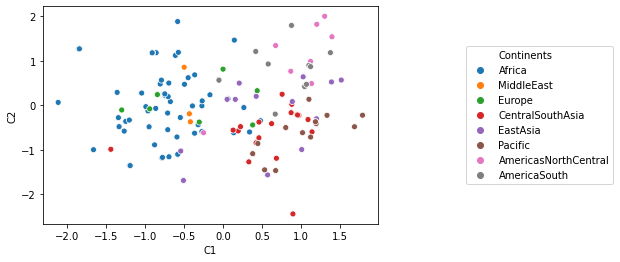

In [132]:
validation_oneout = pd.DataFrame(results_oneout)
validation_oneout['Continents'] = continents
validation_oneout .columns = ['C1','C2','Continents']

g = sns.scatterplot(validation_oneout['C1'], validation_oneout['C2'], hue = validation_oneout['Continents'], legend = "brief")
legend = g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

Plot into clusters:

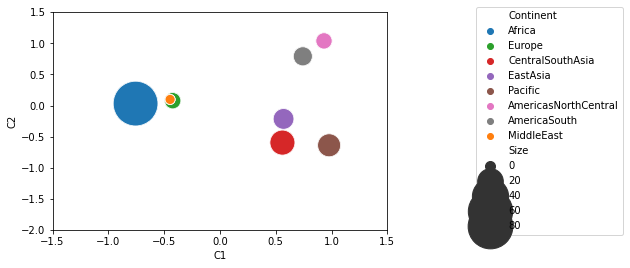

In [133]:
latitude_oneout = np.empty(len(continents))
longitude_oneout = np.empty(len(continents))
size_oneout = np.empty(len(continents))

for i,elements in enumerate(continents): 
  tmp = validation_oneout.loc[result_cca['Continents'] == elements]
  latitude_oneout[i] = np.mean(tmp["C1"])
  longitude_oneout[i] = np.mean(tmp["C2"])
  size_oneout[i] = len(tmp["C1"])

cluster_oneout = pd.DataFrame([latitude_oneout,longitude_oneout,size_oneout,continents]).T
cluster_oneout.columns = ['C1','C2','Size','Continent']

# Change order of continents to prevent Europe from hiding MiddleEast
cluster_oneout_middleeast = cluster_oneout[cluster_oneout['Continent'] == 'MiddleEast']
cluster_oneout_no_middleeast = cluster_oneout[cluster_oneout['Continent'] != 'MiddleEast']
cluster_oneout_ordered = cluster_oneout_no_middleeast.append(cluster_oneout_middleeast)

# Keeping palette consistent with other plots despite change in order
current_palette = sns.color_palette()
color = [current_palette[0],current_palette[2],current_palette[3],current_palette[4],current_palette[5],current_palette[6],current_palette[7],current_palette[1]]

# Plot
g = sns.scatterplot(cluster_oneout_ordered['C1'],cluster_oneout_ordered['C2'],size=cluster_oneout_ordered['Size'],hue=cluster_oneout_ordered['Continent'],sizes=(100,2000),palette=color)

xaxis = plt.xlim(-1.5,1.5)
yaxis = plt.ylim(-2,1.5)

legend = g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

This figure appears very similar to the one obtained through the PCCA analysis with the exception of a mild deviation of the Pacific region.